In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
file_path = '/content/drive/MyDrive/user-wallet-transactions.json'

In [6]:
try:
    df = pd.read_json(file_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please check the path.")
    exit()

Data loaded successfully. Shape: (100000, 13)


In [7]:
action_data_df = pd.json_normalize(df['actionData'])

# Combine actionData columns with the essential top-level columns
df_cleaned = pd.concat([
    df[['userWallet', 'timestamp']],
    action_data_df[['type', 'amount', 'assetSymbol']]
], axis=1)

# Rename columns for consistency
df_cleaned.rename(columns={'userWallet': 'user_id', 'assetSymbol': 'reserve_symbol'}, inplace=True)
print("Data correctly flattened and combined.")

Data correctly flattened and combined.


In [8]:
 #Data Type Conversion
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'], unit='s')
df_cleaned['amount'] = pd.to_numeric(df_cleaned['amount'], errors='coerce')
df_cleaned.dropna(subset=['amount'], inplace=True) # Drop rows where amount couldn't be converted
print("Converted data types.")

Converted data types.


In [9]:
user_summary = df_cleaned.pivot_table(
    index='user_id',
    columns='type',
    values='amount',
    aggfunc=['count', 'sum'],
    fill_value=0
)
user_summary.columns = ['_'.join(col).strip() for col in user_summary.columns.values]


In [10]:
# Calculating Wallet Age and other features
wallet_age = df_cleaned.groupby('user_id')['timestamp'].agg(['min', 'max'])
user_summary['wallet_age_days'] = (wallet_age['max'] - wallet_age['min']).dt.days
user_summary['unique_assets_used'] = df_cleaned.groupby('user_id')['reserve_symbol'].nunique()


In [12]:
# --- Corrected Ratio Calculations ---

# Get columns, substituting a default Series of 0s if they don't exist.
# Using 1 as the default for denominators avoids division by zero.
sum_repay = user_summary.get('sum_repay', 0)
sum_borrow = user_summary.get('sum_borrow', 1)
sum_deposit = user_summary.get('sum_deposit', 1)

# Calculate repayment ratio
user_summary['repayment_ratio'] = (sum_repay / sum_borrow)
# Now clean the entire column (Series)
user_summary['repayment_ratio'] = user_summary['repayment_ratio'].replace([np.inf, -np.inf], 0).fillna(0)
user_summary['repayment_ratio'] = user_summary['repayment_ratio'].apply(lambda x: min(x, 1.0)) # Cap at 100%

# Calculate borrow-to-deposit ratio
user_summary['borrow_to_deposit_ratio'] = (sum_borrow / sum_deposit)
# Clean the entire column
user_summary['borrow_to_deposit_ratio'] = user_summary['borrow_to_deposit_ratio'].replace([np.inf, -np.inf], 0).fillna(0)


print("Ratios calculated successfully.")
print(user_summary[['repayment_ratio', 'borrow_to_deposit_ratio']].head())

Ratios calculated successfully.
                                            repayment_ratio  \
user_id                                                       
0x00000000001accfa9cef68cf5371a23025b6d4b6              0.0   
0x000000000051d07a4fb3bd10121a343d85818da6              0.0   
0x000000000096026fb41fc39f9875d164bd82e2dc              0.0   
0x0000000000e189dd664b9ab08a33c4839953852c              0.0   
0x0000000002032370b971dabd36d72f3e5a7bf1ee              0.0   

                                            borrow_to_deposit_ratio  
user_id                                                              
0x00000000001accfa9cef68cf5371a23025b6d4b6                      1.0  
0x000000000051d07a4fb3bd10121a343d85818da6                      1.0  
0x000000000096026fb41fc39f9875d164bd82e2dc                      1.0  
0x0000000000e189dd664b9ab08a33c4839953852c                      1.0  
0x0000000002032370b971dabd36d72f3e5a7bf1ee                      1.0  


In [13]:
all_txn_types = ['Deposit', 'Borrow', 'Repay', 'RedeemUnderlying', 'LiquidationCall']
for t_type in all_txn_types:
    for agg in ['count', 'sum']:
        col = f'{agg}_{t_type}'
        if col not in user_summary.columns:
            user_summary[col] = 0

In [14]:
print(user_summary.head())

                                            count_Borrow  count_Deposit  \
user_id                                                                   
0x00000000001accfa9cef68cf5371a23025b6d4b6             0              1   
0x000000000051d07a4fb3bd10121a343d85818da6             0              1   
0x000000000096026fb41fc39f9875d164bd82e2dc             0              2   
0x0000000000e189dd664b9ab08a33c4839953852c             0              0   
0x0000000002032370b971dabd36d72f3e5a7bf1ee            15            250   

                                            count_LiquidationCall  \
user_id                                                             
0x00000000001accfa9cef68cf5371a23025b6d4b6                      0   
0x000000000051d07a4fb3bd10121a343d85818da6                      0   
0x000000000096026fb41fc39f9875d164bd82e2dc                      0   
0x0000000000e189dd664b9ab08a33c4839953852c                      0   
0x0000000002032370b971dabd36d72f3e5a7bf1ee                  

In [15]:

from sklearn.preprocessing import MinMaxScaler

# Starting with a base score for all users
user_summary['credit_score'] = 500.0

# --- Apply Scoring Rules ---

# 1. Heavily penalize liquidations (the biggest sign of risk)
user_summary['credit_score'] -= user_summary['count_LiquidationCall'] * 250

# 2. Reward users for a long history (log transform to give diminishing returns)
user_summary['credit_score'] += np.log1p(user_summary['wallet_age_days']) * 20

# 3. Reward users for repaying their loans
user_summary['credit_score'] += user_summary['repayment_ratio'] * 150

# 4. Penalize users with a high borrow-to-deposit ratio
user_summary['credit_score'] -= user_summary['borrow_to_deposit_ratio'] * 100

# 5. Reward users for interacting with multiple assets (shows deeper engagement)
user_summary['credit_score'] += user_summary['unique_assets_used'] * 10


In [16]:
# This ensures the final scores are standardized
scaler = MinMaxScaler(feature_range=(0, 1000))

In [17]:
# Reshape the data because the scaler expects a 2D array
scores = user_summary['credit_score'].values.reshape(-1, 1)
user_summary['final_score'] = scaler.fit_transform(scores)

In [18]:
# Convert to integer for a cleaner look
user_summary['final_score'] = user_summary['final_score'].astype(int)

In [19]:
print(user_summary[[
    'count_LiquidationCall',
    'wallet_age_days',
    'repayment_ratio',
    'borrow_to_deposit_ratio',
    'final_score'
]].sort_values(by='final_score', ascending=False).head(10))

                                            count_LiquidationCall  \
user_id                                                             
0x005f16f017aa933bb41965b52848ceb8ee48b171                      0   
0x000bc61d0a2dfee19346ad4d1fce2fa3c099e0cb                      0   
0x055a875cd844f04a2c2ee1bb72999d7e7b40761d                      0   
0x00ab84845d68063c1dcd2a5f2cead5f253b249a2                      0   
0x05aeaabd4b221dc741b0213dedc1c2fe3613e2c0                      0   
0x00bdc8be263d20bb3a83aaeadfef258dd409e2df                      0   
0x010d23b534006f4e4f174a7530d7d9e3c131732a                      0   
0x007c4bb067d9b6afeb4c13415477d396123c4aa3                      0   
0x02faf4316dcb9330751f3677436aa849aa93851b                      0   
0x04ee10fd378f7cad5ac5751d7cd0f42b13ee3b76                      0   

                                            wallet_age_days  repayment_ratio  \
user_id                                                                        
0x005f16f01

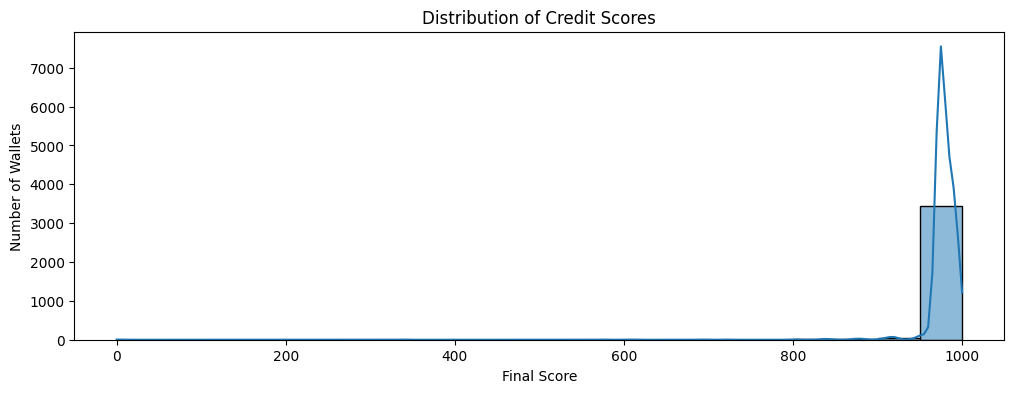

In [21]:
plt.figure(figsize=(12, 4))
sns.histplot(user_summary['final_score'], bins=20, kde=True)
plt.title('Distribution of Credit Scores')
plt.xlabel('Final Score')
plt.ylabel('Number of Wallets')
plt.show()

In [22]:
high_scorers = user_summary[user_summary['final_score'] > 800]
print("--- High Scorer Profile ---")
print(high_scorers.describe())

--- High Scorer Profile ---
       count_Borrow  count_Deposit  count_LiquidationCall  \
count   3491.000000    3491.000000             3491.00000   
mean       4.839301      10.775423                0.04841   
std       15.018583      29.844333                0.33378   
min        0.000000       0.000000                0.00000   
25%        0.000000       1.000000                0.00000   
50%        0.000000       2.000000                0.00000   
75%        3.000000       6.000000                0.00000   
max      200.000000     511.000000                5.00000   

       count_RedeemUnderlying  count_Repay    sum_Borrow   sum_Deposit  \
count             3491.000000  3491.000000  3.491000e+03  3.491000e+03   
mean                 9.234603     3.567459  4.839979e+22  6.299186e+22   
std                242.726170    13.325793  9.426494e+23  1.229498e+24   
min                  0.000000     0.000000  0.000000e+00  0.000000e+00   
25%                  0.000000     0.000000  0.000000

In [23]:
low_scorers = user_summary[user_summary['final_score'] < 200]
print("\n--- Low Scorer Profile ---")
print(low_scorers.describe())


--- Low Scorer Profile ---
       count_Borrow  count_Deposit  count_LiquidationCall  \
count           1.0            1.0                    1.0   
mean          117.0          111.0                   26.0   
std             NaN            NaN                    NaN   
min           117.0          111.0                   26.0   
25%           117.0          111.0                   26.0   
50%           117.0          111.0                   26.0   
75%           117.0          111.0                   26.0   
max           117.0          111.0                   26.0   

       count_RedeemUnderlying  count_Repay    sum_Borrow   sum_Deposit  \
count                     1.0          1.0  1.000000e+00  1.000000e+00   
mean                     34.0         78.0  1.751633e+21  2.540714e+20   
std                       NaN          NaN           NaN           NaN   
min                      34.0         78.0  1.751633e+21  2.540714e+20   
25%                      34.0         78.0  1.751633